In [1]:
import re
import numpy as np
from wrapper_my_radex import myradex_wrapper as wrapper 
from scipy.constants import h,k,c
phy_c_cgs=299792458e2
phy_c_SI=299792458
phy_k_cgs=1.3806503e-16
phy_h_cgs=6.62606896e-27
phy_cm2erg=phy_h_cgs*phy_c_cgs
phy_cm2K=phy_cm2erg/phy_k_cgs
class colli_partner:
    def __init__(self,part_name):
        self.name=part_name
    def set_n_trans(self,n_trans):
        self.n_transitions=n_trans
    def set_n_T(self,n_T):
        self.n_T=n_T
    def set_colli_temp(self,col_temp):
        self.colli_temperature=col_temp
    def set_Cul(self,Cul):
        self.Cul=Cul
class mol_data:
    def __init__(self,mol_dir,mol_file):
        self.mol_dir=mol_dir
        self.mol_file=mol_file
        f=open(self.mol_dir+self.mol_file)
        file_list=re.split('\n',f.read())
        f.close()
        if_read=True
        self.mol_name=re.split(' ',file_list[1])
        self.n_level=int(file_list[5])
        self.level_energy=np.zeros(self.n_level)
        self.level_weight=np.zeros(self.n_level)
        nrow=7
        for i in range(self.n_level):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            self.level_energy[i]=float(line[1])*phy_cm2K
            self.level_weight[i]=float(line[2])
        nrow+=self.n_level+1
        self.n_transitions=int(file_list[nrow])
        nrow+=2
        self.rad_data=np.zeros([self.n_transitions,9]) # iup, ilow, Aul, freq, lambda, Eup, Elow, Bul, Blu
        for i in range(self.n_transitions):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            iu=int(line[1])
            il=int(line[2])
            self.rad_data[i,0]=iu
            self.rad_data[i,1]=il
            self.rad_data[i,2]=float(line[3])
            self.rad_data[i,3]=phy_c_cgs*(self.level_energy[iu-1]-self.level_energy[il-1])/phy_cm2K
            self.rad_data[i,4]=phy_c_SI/self.rad_data[i,3]*1e6  # micron
            self.rad_data[i,5]=self.level_energy[iu-1]
            self.rad_data[i,6]=self.level_energy[il-1]
            self.rad_data[i,7]=self.rad_data[i,2]/((2*phy_h_cgs/phy_c_cgs**2)*self.rad_data[i,3]**3)
            self.rad_data[i,8]=self.rad_data[i,7]*self.level_weight[iu-1]/self.level_weight[il-1]
        nrow+=self.n_transitions+1
        self.n_partner=int(file_list[nrow])
        nrow+=2
        self.colli_data={}
        for i in range(self.n_partner):
            line=re.split(' |-|\t|\+|:',file_list[nrow])
            line=[item for item in line if item!='']
            part_name=line[2]
            if part_name=='electron':
                part_name='e'
            elif part_name=='with':
                part_name=line[3]
            partner=colli_partner(part_name)
            partner.set_n_trans(int(file_list[nrow+2]))
            partner.set_n_T(int(file_list[nrow+4]))
            line=re.split(' |\t',file_list[nrow+6])
            line=np.array([item for item in line if item!=''])
            partner.set_colli_temp(line.astype(float))
            Cul=np.zeros([partner.n_transitions,partner.n_T+2])
            for j in range(partner.n_transitions):
                line=re.split(' |\t',file_list[nrow+8+j])
                line=np.array([item for item in line if item!=''])
                Cul[j]=line[1:].astype(float)
            partner.set_Cul(Cul.T)
            self.colli_data[part_name]=partner
            nrow+=9+partner.n_transitions
        self.data_shape=[self.n_level,self.n_transitions,self.n_partner]
        self.partner_names=list(self.colli_data.keys())
        self.colli_shape=[[self.colli_data[key].n_transitions,self.colli_data[key].n_T] for key in self.colli_data.keys()]
        self.level_data=np.concatenate([[self.level_energy],[self.level_weight]],axis=0).T
        colli_T=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])])
        colli_Cul=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])+2,max([self.colli_data[key].n_transitions for key in self.partner_names])])
        for i in range(self.n_partner):
            partner_name=self.partner_names[i]
            colli_T[i,:self.colli_data[partner_name].n_T]=self.colli_data[partner_name].colli_temperature
            colli_Cul[i,:self.colli_data[partner_name].n_T+2,:self.colli_data[partner_name].n_transitions]=self.colli_data[partner_name].Cul
        self.colli_T=colli_T
        self.colli_Cul=colli_Cul
        space=' '
        self.part_name_str=space.join(self.partner_names)
def modified_blackbody(wl,T,A,b):
    #the input wavelength is in unit of um      
    wl_m=wl*1e-6
    v=c/wl_m
    return A*wl_m**(-b)*2*h*v**3/ c**2 / (np.exp(h*v / (k*T)) - 1)
def compute_Ncol(nH2,abundance_Kvir):    
    Ncol=3.08e18*nH2*abundance_Kvir*velocity_FWHM/1e5/(0.65*1.5**0.5*(nH2/1e3)**0.5)  #Papadopoulos et al. (2012)  Tunnard et al. (2015)
    return Ncol
def compute_Kvir(nH2,NH2col):
    Kvir=NH2col/(3.08e18*nH2*velocity_FWHM/1e5/(0.65*1.5**0.5*(nH2/1e3)**0.5))
    return Kvir
def Tbtoflux(Tb,freq,solid_angle):              #K, Hz, arcsec^2
    I_nu=2*phy_k_cgs*Tb*freq**2/(phy_c_cgs)**2          #Essensial Radio Astronomy P35
    flux=I_nu*solid_angle/(180/np.pi*3600)**2 *1e23 *velocity_FWHM/1e5               #Jykm/s  #Essensial Radio Astronomy P50
    return flux
def compute_gasmass(NH2col,solid_angle):
    area=solid_angle*ang_phy**2  #pc^2
    gasmass=NH2col*(2*1.66053904e-24)*area*3.08567758e18**2/1.98855e33 #solar mass
    return gasmass
def best_fitting(samples):
    nparm=samples.shape[-1]
    result=np.zeros([nparm,3])
    for i in range(nparm):
        mcmc=np.percentile(samples[:,i],[16,50,84])
        q=np.diff(mcmc)
        result[i]=[mcmc[1],-q[0],q[1]]
    return result
def dust_SED(wl_um,Tkin,mass):
    b=2
    dust_mass=mass/gas_dust
    A=dust_mass/((distance*3.0857*10**24)**2/3.98/(250*10**(-6))**b/1.9891e33*1e-26)
    fluxes=modified_blackbody(wl_um,Tkin,A,b)
    return fluxes
def limit_f(x,llim,ulim):
    if llim<x<ulim:
        return 0
    elif x<llim:
        return -0.5*((x-llim)/0.01)**4
    else:
        return -0.5*((x-ulim)/0.01)**4
def run_myradex(Tkin,nH2,NXcol,Tbg,molecule,ini_occ=[]):
    if len(ini_occ)==0:
        ini_occ=molecule.level_weight*np.exp(-molecule.level_energy/Tkin)
        ini_occ=ini_occ/sum(ini_occ)
    params = {'tkin': Tkin,
              'ncol_x_cgs': NXcol,
              'h2_density_cgs': nH2,
              'tbg':Tbg,
              'mol_name':molecule.mol_name[0],
              'data_shape':molecule.data_shape,
              'n_transition':molecule.data_shape[1],
              'partner_names':molecule.part_name_str,
              'colli_shape':molecule.colli_shape,
              'level_data':molecule.level_data,
              'rad_data':molecule.rad_data,
              'colli_t':molecule.colli_T,
              'colli_data':molecule.colli_Cul,
              'ini_occ':ini_occ}      #initial occupation
    Tb,f_occupation=wrapper.run_one_params(**params)
    return Tb,f_occupation

In [2]:
source_name='NGC6240'
distance=103.1        #Mpc
ang_phy=np.pi/180/3600*distance*1e6    #pc/arcsec
Tbg=2.73                        #K
velocity_FWHM=360e5   #cm/s
gas_dust=100
co_Jup=np.arange(13)+1
co_flux=np.array([322,1492,3205,4634,5636,5913,6009,5833,4769,4162,3161,2592,2081])
co_err=np.array([29,253,642,371,149,82,60,89,82,67,74,60,60])
co_err[1:5]=co_err[1:5]/4
hcn_Jup=np.arange(4)+1
hcn_flux=np.array([14,61,74,41])
hcn_err=np.array([2,15,7,6])
hco_Jup=np.arange(4)+1
hco_flux=np.array([21,83,141,74])
hco_err=np.array([3,15,21,9])
dust_wl=np.array([24,60,70,100,160,250,350,500])
dust_flux=np.array([2.9,22.9,25,26.2,17.2,5.8,2,0.6])
dust_error=dust_flux*0.1
beam_size={'co':np.array([22,14,11,42.8,35.2,31.2,35.9,40.1,19.0,17.4,17.3,16.9,16.6]),
           'hcn':np.array([40,30,20,15]),
           'hco':np.array([40,30,20,15])}
co_mol=mol_data('/home/zj/Documents/radex_mol/','co.dat')
hcn_mol=mol_data('/home/zj/Documents/radex_mol/','hcn.dat')
hco_mol=mol_data('/home/zj/Documents/radex_mol/','hco+@xpol.dat')

In [10]:
class gas_compnent:
    def __init__(self,Tkin,nH2,Ncol,co_ab,hcn_ab,hco_ab,solidangle):
        self.Tkin,self.nH2,self.Ncol,self.co_ab,self.hcn_ab,self.hco_ab,self.solidangle=\
                Tkin,nH2,Ncol,co_ab,hcn_ab,hco_ab,solidangle
        self.co_Ncol=Ncol*co_ab
        self.hcn_Ncol=Ncol*hcn_ab
        self.hco_Ncol=Ncol*hco_ab
        self.Kvir=compute_Kvir(self.nH2,self.Ncol)
    def compute_Tbs(self):
        self.co_Tb,self.co_occupation=run_myradex(self.Tkin,self.nH2,self.co_Ncol/(velocity_FWHM/1e5),Tbg,co_mol)
        self.hcn_Tb,self.hcn_occupation=run_myradex(self.Tkin,self.nH2,self.hcn_Ncol/(velocity_FWHM/1e5),Tbg,hcn_mol)
        self.hco_Tb,self.hco_occupation=run_myradex(self.Tkin,self.nH2,self.hco_Ncol/(velocity_FWHM/1e5),Tbg,hco_mol)
    def compute_flux(self):
        self.compute_Tbs()
        self.co_flux=Tbtoflux(self.co_Tb,co_mol.rad_data[:,3],self.solidangle)
        self.hcn_flux=Tbtoflux(self.hcn_Tb,hcn_mol.rad_data[:,3],self.solidangle)
        self.hco_flux=Tbtoflux(self.hco_Tb,hco_mol.rad_data[:,3],self.solidangle)
        return self.co_flux,self.hcn_flux,self.hco_flux
    def compute_mass(self):
        self.gasmass=compute_gasmass(self.Ncol,self.solidangle)
        return self.gasmass

def is_physical(params):
    lg_ab_hcn,lg_ab_hco,lg_ab_co,lg_Tkin_1,lg_nH2_1,lg_Ncol_1,lg_solidang_1,lg_Tkin_2,lg_nH2_2,\
            lg_Ncol_2,lg_solidang_2,lg_Tkin_3,lg_nH2_3,lg_Ncol_3,lg_solidang_3=params
    Kvir_1=compute_Kvir(10**lg_nH2_1,10**lg_Ncol_1)
    Kvir_2=compute_Kvir(10**lg_nH2_2,10**lg_Ncol_2)
    Kvir_3=compute_Kvir(10**lg_nH2_3,10**lg_Ncol_3)
    isphy1=limit_f(lg_Tkin_1,1,3)+limit_f(lg_nH2_1,1,6)+limit_f(lg_solidang_1,-8,np.log10(4))+limit_f(Kvir_1,0.5,3)
    isphy2=limit_f(lg_Tkin_2,1,3)+limit_f(lg_nH2_2,1,6)+limit_f(lg_solidang_2,-8,np.log10(4))+limit_f(Kvir_2,0.5,10)
    isphy3=limit_f(lg_Tkin_3,1,3)+limit_f(lg_nH2_3,1,6)+limit_f(lg_solidang_3,-8,np.log10(4))+limit_f(Kvir_3,0.5,50)
    isphyab=limit_f(lg_ab_hcn,-10,-4)+limit_f(lg_ab_hco,-10,-4)+limit_f(lg_ab_co,-7,-2)
    return isphy1+isphy2+isphy3+isphyab
def log_likelyhood(params):
    ll_phy=is_physical(params)
    ab_hcn,ab_hco,ab_co,Tkin_1,nH2_1,Ncol_1,solidang_1,Tkin_2,nH2_2,Ncol_2,solidang_2,Tkin_3,nH2_3,Ncol_3,solidang_3=10**params
    gas_comp1=gas_compnent(Tkin_1,nH2_1,Ncol_1,ab_co,ab_hcn,ab_hco,solidang_1)
    gas_comp2=gas_compnent(Tkin_2,nH2_2,Ncol_2,ab_co,ab_hcn,ab_hco,solidang_2)
    gas_comp3=gas_compnent(Tkin_3,nH2_3,Ncol_3,ab_co,ab_hcn,ab_hco,solidang_3)
    model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
    model_co_flux_2,model_hcn_flux_2,model_hco_flux_2=gas_comp2.compute_flux()
    model_co_flux_3,model_hcn_flux_3,model_hco_flux_3=gas_comp3.compute_flux()
    
    ll_co=-0.5*np.sum(((co_flux-model_co_flux_1[co_Jup-1]-model_co_flux_2[co_Jup-1]-model_co_flux_3[co_Jup-1])/co_err)**2)
    ll_peak=limit_f(max(model_co_flux_2),0.1*max(co_flux),10*max(co_flux))+limit_f(max(model_co_flux_3),0.1*max(co_flux),10*max(co_flux))
    ll_hcn=-0.5*np.sum(((hcn_flux-model_hcn_flux_1[hcn_Jup-1]-model_hcn_flux_2[hcn_Jup-1]-model_hcn_flux_3[hcn_Jup-1])/hcn_err)**2)
    ll_hco=-0.5*np.sum(((hco_flux-model_hco_flux_1[hco_Jup-1]-model_hco_flux_2[hco_Jup-1]-model_hco_flux_3[hco_Jup-1])/hco_err)**2)
    ll_prior=log_prior(params)
    ll_abs=-0.5*(np.sum((co_flux-model_co_flux_1[co_Jup-1]-model_co_flux_2[co_Jup-1])/co_err)+\
                 np.sum((hcn_flux-model_hcn_flux_1[hcn_Jup-1]-model_hcn_flux_2[hcn_Jup-1])/hcn_err)+\
                 np.sum((hco_flux-model_hco_flux_1[hco_Jup-1]-model_hco_flux_2[hco_Jup-1])/hco_err))
    ll=ll_co+ll_hcn+ll_hco+ll_prior+ll_phy+ll_peak
    if np.isnan(ll):
        return -np.inf
    else:
        return ll
def log_prior(params):
    lg_ab_hcn,lg_ab_hco,lg_ab_co,lg_Tkin_1,lg_nH2_1,lg_Ncol_1,lg_solidang_1,lg_Tkin_2,lg_nH2_2,\
            lg_Ncol_2,lg_solidang_2,lg_Tkin_3,lg_nH2_3,lg_Ncol_3,lg_solidang_3=params
    ll_Tkin=-0.5*((lg_Tkin_1-1.3)/0.1)**2
    ll_nH2=-0.5*((lg_nH2_1-4.8)/0.3)**2
    ll=ll_Tkin + ll_nH2
    return ll
log_likelyhood(np.array([-8.0,-8.5,-4, 1.4,4.8,np.log10(compute_Ncol(10**4.8,1)),0,
   1.7,4.3,np.log10(compute_Ncol(10**4.3,1)),0,2.8,3,np.log10(compute_Ncol(10**3,1)),0]))

-152962.6449813128

In [12]:
param_g=[-8.0,-8.5,-4, 1.4,4.8,np.log10(compute_Ncol(10**4.8,1)),0,
   1.7,3,np.log10(compute_Ncol(10**3,1)),0,2.8,3,np.log10(compute_Ncol(10**3,1)),0]
guess_range=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
narrow_gauss=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
p0=param_g+guess_range* np.random.randn(40, 15)
nwalkers, ndim = p0.shape
import emcee
from multiprocessing import Pool
import os
with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelyhood, args=(),pool=pool)
    state=sampler.run_mcmc(p0,3000,progress=True)

100%|██████████| 3000/3000 [14:00<00:00,  3.57it/s]


(1000, 40, 15)


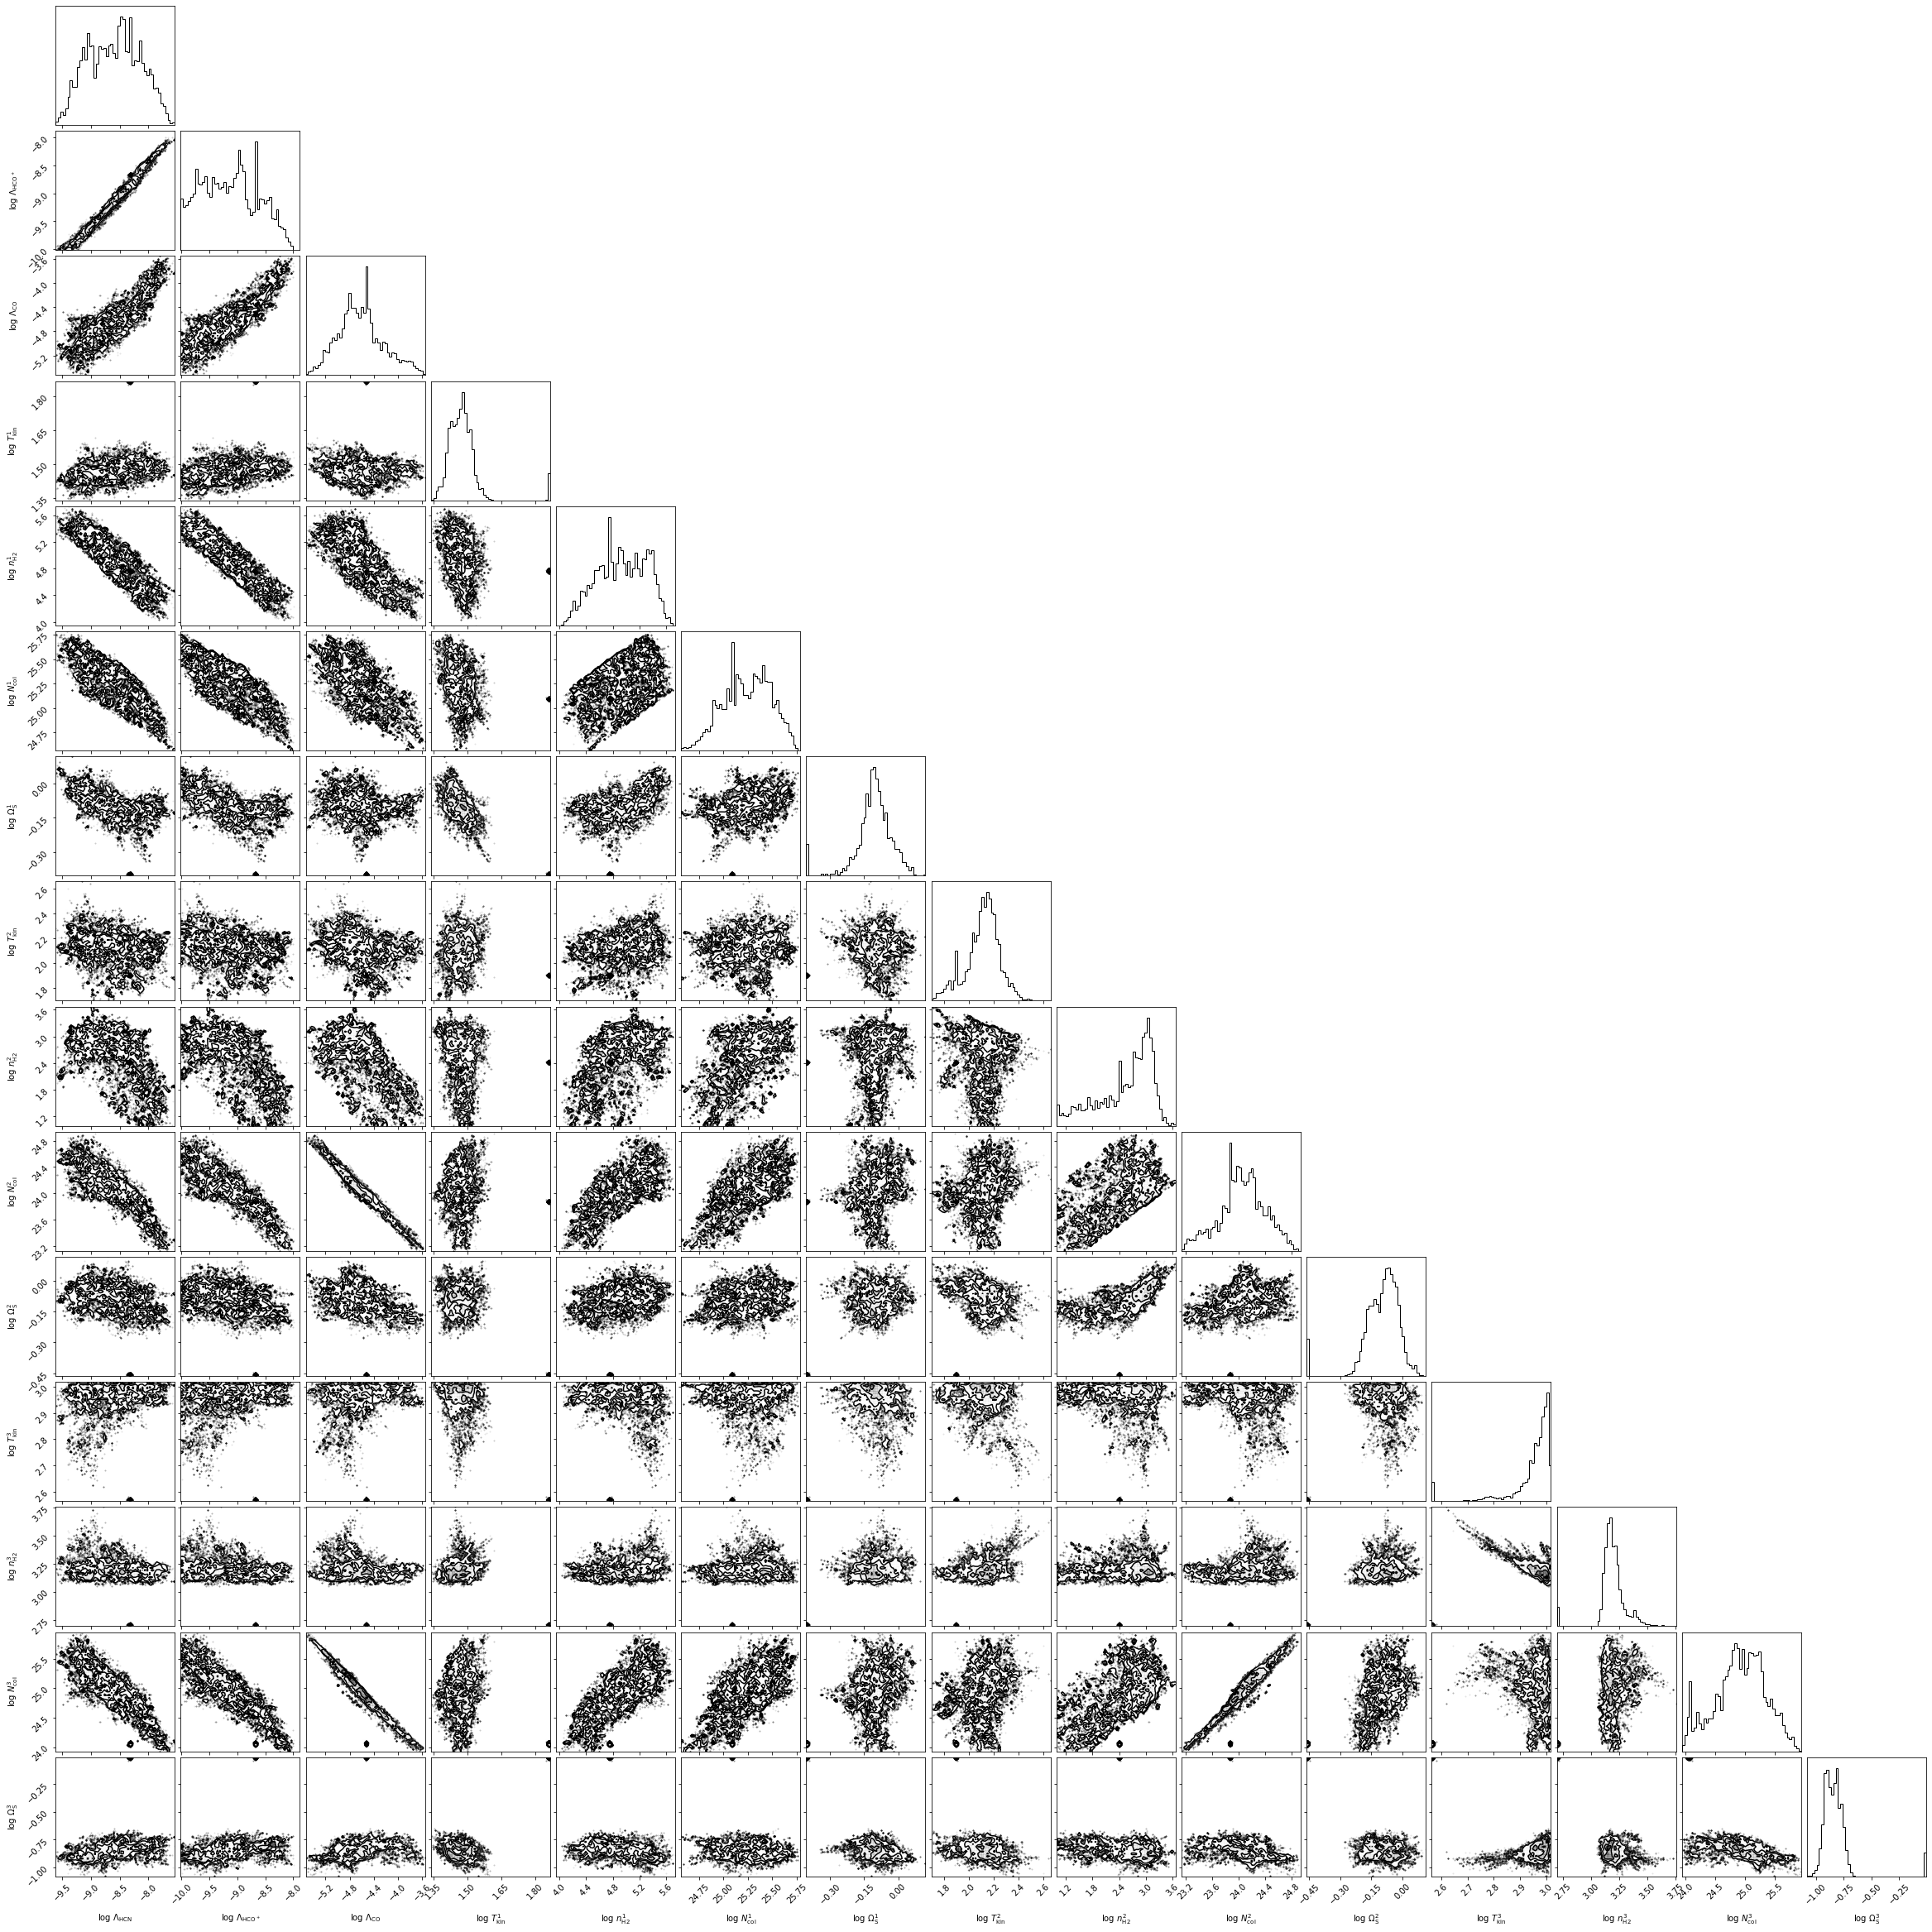

In [13]:
samples=sampler.get_chain(discard=2000)
log_prob_samples = sampler.get_log_prob(discard=2000)
max_index=np.where(log_prob_samples==np.max(log_prob_samples))
max_params=samples[max_index[0][0],max_index[1][0]]
print(samples.shape)
def best_fitting(samples):
    nparm=samples.shape[-1]
    result=np.zeros([nparm,3])
    for i in range(nparm):
        mcmc=np.percentile(samples[:,i],[16,50,84])
        q=np.diff(mcmc)
        result[i]=[mcmc[1],-q[0],q[1]]
    return result

import matplotlib.pyplot as plt
import corner
sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
sample_flag=sample_reshape
pdf_params=best_fitting(sample_flag)
rng = [(x.min(),x.max()) for x in sample_flag.T]
fig=corner.corner(sample_flag, labels=[r"log $\Lambda_{\rm HCN}$", r"log $\Lambda_{\rm HCO^+}$",r"log $\Lambda_{\rm CO}$",
                                       r"log $T^1_{\rm kin}$",r"log $n^1_{\rm H2}$",r"log $N^1_{\rm col}$",
                                       r"log $\Omega^1_{\rm S}$",
                                       r"log $T^2_{\rm kin}$",r"log $n^2_{\rm H2}$",r"log $N^2_{\rm col}$",
                                       r"log $\Omega^2_{\rm S}$",
                                       r"log $T^3_{\rm kin}$",r"log $n^3_{\rm H2}$",r"log $N^3_{\rm col}$",
                                       r"log $\Omega^3_{\rm S}$",r"log $T_{\rm wdust}$"],
                  range=rng,bins=50)
fig.savefig("three_component/corner.png")

maximum likelyhood parameters: [-9.21973297 -9.86872707 -5.06710222  1.43239196  5.28529341 25.62160924
 -0.05886912  2.15111591  3.10200656 24.43367618 -0.04800854  2.9801894
  3.14933963 25.44511433 -0.89182426]
three components gas mass: 145161296693.55377 9655579892.113926 14203677184.710276


7.150694892895442

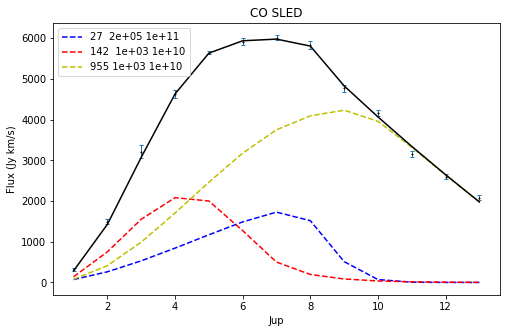

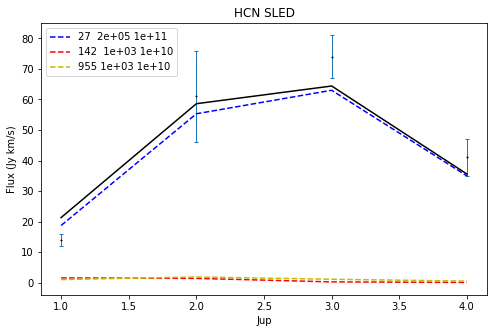

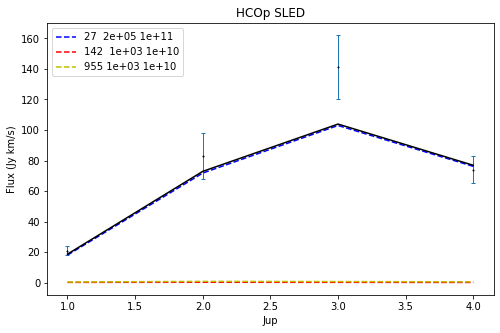

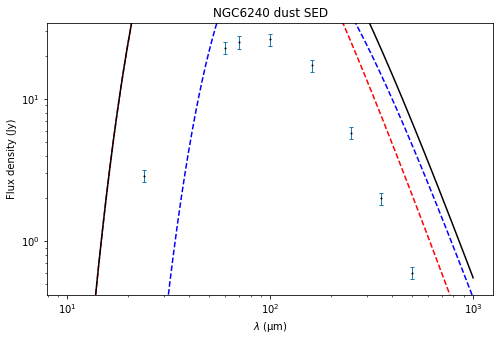

In [17]:
max_params_rc=max_params*1
print("maximum likelyhood parameters:",max_params)
max_params_rc=max_params+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ab_hcn,ab_hco,ab_co,Tkin_1,nH2_1,Ncol_1,solidang_1,Tkin_2,nH2_2,Ncol_2,solidang_2,Tkin_3,nH2_3,Ncol_3,solidang_3=10**max_params
gas_comp1=gas_compnent(Tkin_1,nH2_1,Ncol_1,ab_co,ab_hcn,ab_hco,solidang_1)
gas_comp2=gas_compnent(Tkin_2,nH2_2,Ncol_2,ab_co,ab_hcn,ab_hco,solidang_2)
gas_comp3=gas_compnent(Tkin_3,nH2_3,Ncol_3,ab_co,ab_hcn,ab_hco,solidang_3)
model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
model_co_flux_2,model_hcn_flux_2,model_hco_flux_2=gas_comp2.compute_flux()
model_co_flux_3,model_hcn_flux_3,model_hco_flux_3=gas_comp3.compute_flux()

print('three components gas mass:',gas_comp1.compute_mass(),gas_comp2.compute_mass(),gas_comp3.compute_mass())
import matplotlib.pyplot as plt
def draw_SLED(flux,error,model1,model2,model3,Jup,name):
    fig=plt.figure(figsize=[8,5])
    plt.errorbar(Jup,flux,yerr=error,fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
    J_new=np.linspace(1,5,1000)
    l1=plt.plot(Jup,model1[Jup-1],'b--',label='%.0f  %.0e %.0e'%(gas_comp1.Tkin,gas_comp1.nH2,gas_comp1.gasmass))
    l2=plt.plot(Jup,model2[Jup-1],'r--',label='%.0f  %.0e %.0e'%(gas_comp2.Tkin,gas_comp2.nH2,gas_comp2.gasmass))
    l3=plt.plot(Jup,model3[Jup-1],'y--',label='%.0f %.0e %.0e'%(gas_comp3.Tkin,gas_comp3.nH2,gas_comp3.gasmass))
    lt=plt.plot(Jup,model1[Jup-1]+model2[Jup-1]+model3[Jup-1],'k-')
    plt.title('%s SLED'%(name))
    #plt.plot(J_new,smooth)
    plt.xlabel('Jup')
    plt.legend(loc='upper left')
    #plt.yscale('log')
    plt.ylabel('Flux (Jy km/s)')
    plt.savefig('three_component/'+source_name+'_%s.pdf'%(name))
def draw_SED(dust_wl,dust_flux,dust_error):
    fig=plt.figure(figsize=[8,5])
    plt.errorbar(dust_wl,dust_flux,yerr=dust_error,fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
    wl_new=np.logspace(1,3,1000)
    plt.plot(wl_new,dust_SED(wl_new,gas_comp1.Tkin,gas_comp1.compute_mass()),'b--')
    plt.plot(wl_new,dust_SED(wl_new,Twdust,gas_comp2.compute_mass()+gas_comp3.compute_mass()),'r--')
    plt.plot(wl_new,dust_SED(wl_new,gas_comp1.Tkin,gas_comp1.compute_mass())+dust_SED(wl_new,Twdust,gas_comp2.compute_mass()+gas_comp3.compute_mass()),'k-')
    plt.title('%s dust SED'%(source_name))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([min(dust_flux-dust_error*3),max(dust_flux+dust_error*3)])
    plt.xlabel(r'$\lambda~\rm (\mu m)$')
    plt.ylabel('Flux density (Jy)')
    plt.savefig('three_component/'+source_name+'_dust.pdf')
draw_SLED(co_flux,co_err,model_co_flux_1,model_co_flux_2,model_co_flux_3,co_Jup,'CO')
draw_SLED(hcn_flux,hcn_err,model_hcn_flux_1,model_hcn_flux_2,model_hcn_flux_3,hcn_Jup,'HCN')
draw_SLED(hco_flux,hco_err,model_hco_flux_1,model_hco_flux_2,model_hco_flux_3,hco_Jup,'HCOp')
draw_SED(dust_wl,dust_flux,dust_error)
Kvir1=compute_Kvir(10**sample_reshape[:,4],10**sample_reshape[:,5])
Kvir2=compute_Kvir(10**sample_reshape[:,8],10**sample_reshape[:,9])
Kvir3=compute_Kvir(10**sample_reshape[:,12],10**sample_reshape[:,13])
np.mean(Kvir3)